In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier
import category_encoders as ce
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
url_train='/kaggle/input/playground-series-s4e8/train.csv'
url_test='/kaggle/input/playground-series-s4e8/test.csv'
train=pd.read_csv(url_train,sep=',')
test=pd.read_csv(url_test,sep=',')
print(train.shape)
print(test.shape)

(3116945, 22)
(2077964, 21)


In [4]:
# Drop id
train=train.drop(columns=['id'])
test=test.drop(columns=['id'])

class
p    1705396
e    1411549
Name: count, dtype: int64


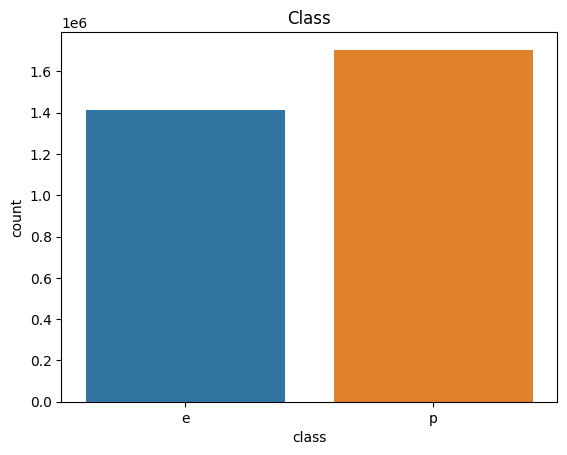

In [5]:
# Target 
print(train['class'].value_counts())
sns.countplot(data=train,x='class')
plt.title('Class')
plt.show()

In [6]:
missing_train = train.isna().mean() * 100
missing_test = test.isna().mean() * 100

In [7]:
missing_threshold = 0.90
high_missing_columns = train.columns[train.isnull().mean() > missing_threshold]
high_missing_columns

Index(['veil-type', 'spore-print-color'], dtype='object')

In [8]:
train=train.drop(columns=high_missing_columns)
test=test.drop(columns=high_missing_columns)
target='class'
for column in train.columns:
    if train[column].isnull().any():      
        if train[column].dtype == 'object':
            mode_value = train[column].mode()[0]
            train[column].fillna(mode_value, inplace=True)
            test[column].fillna(mode_value, inplace=True)     
        else:
            median_value = train[column].median()
            train[column].fillna(median_value, inplace=True)
            test[column].fillna(median_value, inplace=True)

In [9]:
cols_to_drop_train=missing_train[missing_train>85].index
cols_to_drop_test = missing_test[missing_test >85].index
print(cols_to_drop_train)
print(cols_to_drop_test)

Index(['stem-root', 'veil-type', 'veil-color', 'spore-print-color'], dtype='object')
Index(['stem-root', 'veil-type', 'veil-color', 'spore-print-color'], dtype='object')


In [10]:
def knn_impute(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [11]:
df_train_imputed=knn_impute(train,n_neighbors=5)
df_test_imputed=knn_impute(test,n_neighbors=5)

In [12]:
cat_cols_train=df_train_imputed.select_dtypes(include=['object']).columns
#print(cat_cols_train)
cat_cols_train=cat_cols_train[cat_cols_train!='class']
ordinal_encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [13]:
df_train=df_train_imputed.copy()
df_test=df_test_imputed.copy()

In [14]:
le=LabelEncoder()
df_train['class']=le.fit_transform(df_train['class'])
y=df_train['class']
X=df_train.drop(['class'],axis=1)

In [15]:
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state =42,stratify=y)

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Definir el modelo base
model = XGBClassifier(
    objective='binary:logistic',
    random_state=42  # Establecer la semilla para reproducibilidad
)

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'alpha': uniform(0, 1),               # Regularización L1
    'subsample': uniform(0.5, 0.5),       # Submuestreo de filas
    'colsample_bytree': uniform(0.5, 0.5),# Submuestreo de columnas
    'max_depth': [4, 6, 8, 10, 12, 14],   # Profundidad máxima
    'min_child_weight': [1, 3, 5, 7],     # Peso mínimo de los hijos
    'gamma': uniform(1e-8, 1e-3),         # Regularización gamma
    'n_estimators': [50, 100, 150, 200]   # Número de árboles
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,                   # Número de combinaciones a probar
    scoring='accuracy',          # Métrica de evaluación
    cv=3,                        # Validación cruzada con 3 particiones
    verbose=1,                   # Mostrar progreso
    random_state=42,             # Semilla para reproducibilidad
    n_jobs=-1                    # Paralelización
)

# Ejecutar la búsqueda
random_search.fit(train_X, train_y)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros: {'alpha': 0.5166358912710143, 'colsample_bytree': 0.6304145874152045, 'gamma': 0.0009962636997579242, 'max_depth': 14, 'min_child_weight': 7, 'n_estimators': 50, 'subsample': 0.9502090285816652}


In [17]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [18]:
# Entrenar el modelo final con los mejores parámetros
best_model = random_search.best_estimator_
best_model.fit(
    train_X, 
    train_y, 
    eval_set=[(test_X, test_y)],
    eval_metric=mcc_metric
)

# Evaluar el modelo
print("Score en test set:", best_model.score(test_X, test_y))

[0]	validation_0-logloss:0.47242	validation_0-mcc:0.90185
[1]	validation_0-logloss:0.34675	validation_0-mcc:0.94727
[2]	validation_0-logloss:0.26801	validation_0-mcc:0.95894
[3]	validation_0-logloss:0.20143	validation_0-mcc:0.96842
[4]	validation_0-logloss:0.15923	validation_0-mcc:0.97250
[5]	validation_0-logloss:0.12895	validation_0-mcc:0.97467
[6]	validation_0-logloss:0.10830	validation_0-mcc:0.97678
[7]	validation_0-logloss:0.09179	validation_0-mcc:0.97764
[8]	validation_0-logloss:0.07870	validation_0-mcc:0.97837
[9]	validation_0-logloss:0.06871	validation_0-mcc:0.97929
[10]	validation_0-logloss:0.06095	validation_0-mcc:0.97997
[11]	validation_0-logloss:0.05530	validation_0-mcc:0.98039
[12]	validation_0-logloss:0.05172	validation_0-mcc:0.98056
[13]	validation_0-logloss:0.04874	validation_0-mcc:0.98087
[14]	validation_0-logloss:0.04731	validation_0-mcc:0.98088
[15]	validation_0-logloss:0.04613	validation_0-mcc:0.98096
[16]	validation_0-logloss:0.04434	validation_0-mcc:0.98119
[17]	va

In [19]:
y_pred = best_model.predict(test_X)

In [20]:
score = matthews_corrcoef(test_y, y_pred)
print('MCC:', round(score*100,2), '%')

MCC: 98.28 %


In [21]:
test_pred_prob=best_model.predict(df_test)
test_pred_class=le.inverse_transform(test_pred_prob)

In [22]:
sub='/kaggle/input/playground-series-s4e8/sample_submission.csv'
df_sub=pd.read_csv(sub,sep=',')
df_sub['class']= test_pred_class
df_sub.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [23]:
df_sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e


In [24]:
df_sub['class'].value_counts()

class
p    1133100
e     944864
Name: count, dtype: int64

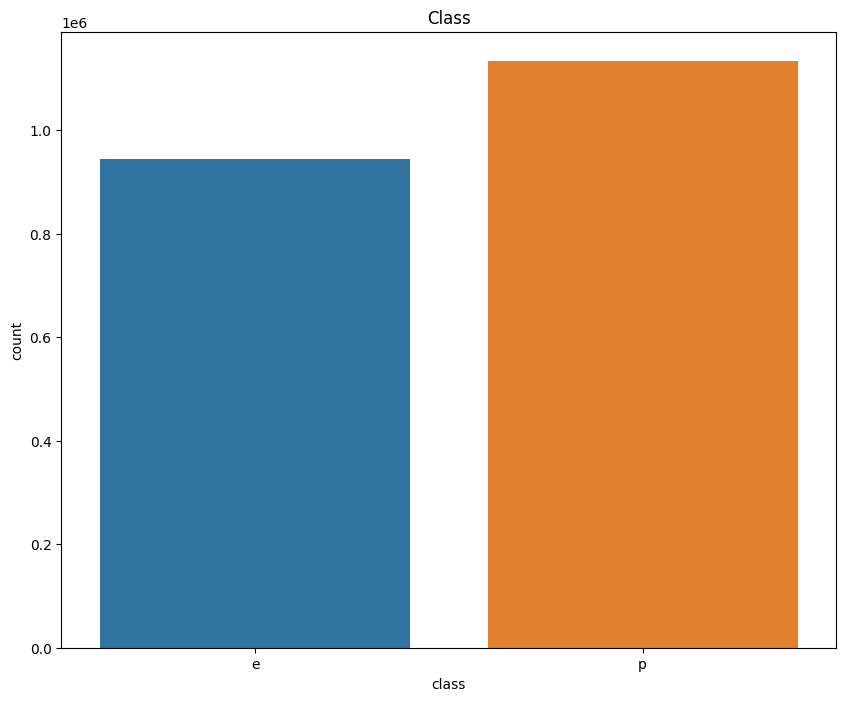

In [25]:
plt.figure(figsize=(10,8))
sns.countplot(data=df_sub,x='class')
plt.title('Class',fontsize=12)
plt.show()